# Time Series in Python
# Practical approach
# Homework task

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

In [4]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline



from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

В этой домашней работе вам предстоит поработать с двумя временными рядами, один - уже знакомый ряд с тратой внутриигровой валюты `currency`, второй - установки по дням в одном из наших приложений, `installs`

In [13]:
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])
installs = pd.read_csv('data/installs.csv', index_col=['Time'], parse_dates=['Time'])

In [14]:
currency.columns

Index(['GEMS_GEMS_SPENT'], dtype='object')

Снова посмотрим на графики временных рядов

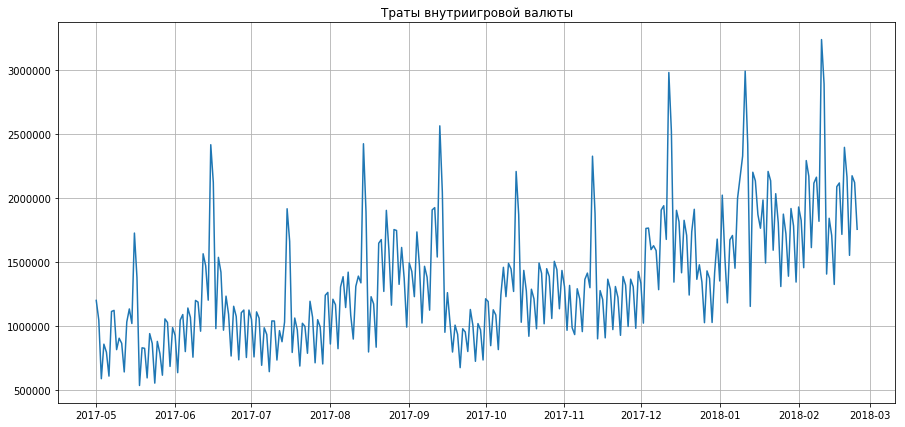

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

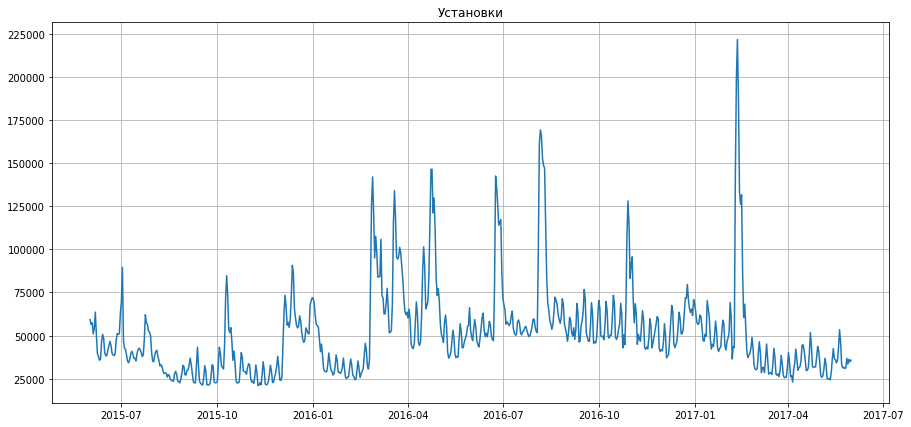

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(installs)
plt.title('Установки')
plt.grid(True)
plt.show()

У первого временного ряда явно есть и сезонность, и тренд, а вот второй ряд с установками имеет очень много выбросов, которые никак не характеризуются сезонными изменениями.

Для начала поработаем с моделью тройного экспоненциального сглаживания - моделью Хольта-Винтерса

In [17]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters            

In [18]:
""" Попробуем try except"""


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):           # БЫЛО !!!!  slen=24
# принимает на вход - params: параметры модели, alpha, betta, gamma - для модели хольта-винтерса
# временной ряд     - series   
# функция ошибок    - loss_function, которую захотим минимизировать
# длинна сезонности  - slen
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) # Вернет генератор по исходному врменному ряду (по схеме на картинке)
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    
       
    for train, test in tscv.split(values):
        try:
            model = HoltWinters(series=values[train], slen=slen, # каждый раз на прошлом обучаем модель
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
            model.triple_exponential_smoothing() # сглаживаем модель      
            predictions = model.result[-len(test):] # считаем прогнозность
            actual = values[test] # и зваписывать, какая была ошибка на будущих значениях
            error = loss_function(predictions, actual)
            errors.append(error)
        
        
        except ValueError:
            continue        
    
    return np.mean(np.array(errors)) # посчитаем среднее по все фолдам

In [19]:

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):           # БЫЛО !!!!  slen=24
# принимает на вход - params: параметры модели, alpha, betta, gamma - для модели хольта-винтерса
# временной ряд     - series   
# функция ошибок    - loss_function, которую захотим минимизировать
# длинна сезонности  - slen
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) # Вернет генератор по исходному врменному ряду (по схеме на картинке)
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    
    
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, # каждый раз на прошлом обучаем модель
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing() # сглаживаем модель
        
        predictions = model.result[-len(test):] # считаем прогнозность
        actual = values[test] # и зваписывать, какая была ошибка на будущих значениях
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors)) # посчитаем среднее по все фолдам

In [20]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

Задание:

- Построить модель для временного ряда с установками, используя `mean_squared_error` в качестве функции потерь
- Сначала постройте модель на всём ряду installs.Users, отложив только последние 50 наблюдений для тестирования, убедитесь, что прогноз по такой модели будет сильно заниженным
- Теперь возьмите для моделирования только последние 500 наблюдений, для этого возьмите от временного ряда срез [500:-50], чтобы учесть в модели только последние изменения и не пытаться подогнать параметры под историю, которая уже стала нерелевантной

In [23]:
%%time

data = installs.Users[0:-50] # отложим 50 наблюдений для тестирования
slen = 7 # недельная сезонность
# инициализируем значения параметров
x = [0, 0, 0]  # просто нулями

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x,  # минимизируем функцию timeseriesCVscore 
               args=(data,mean_squared_error , #,  было mean_squared_log_error
                     slen), # ??????????????????
               method="TNC", bounds = ((0, 1),(0, 1), (0, 1))# диапазоны альфы, бетты и гаммы
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)



model = HoltWinters(data, slen = slen,  # получаем обученную готовую модель с оптимальными значениями параметров, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.14958909808889503 0.02648771746164602 0.1278615041821196
Wall time: 24.1 s


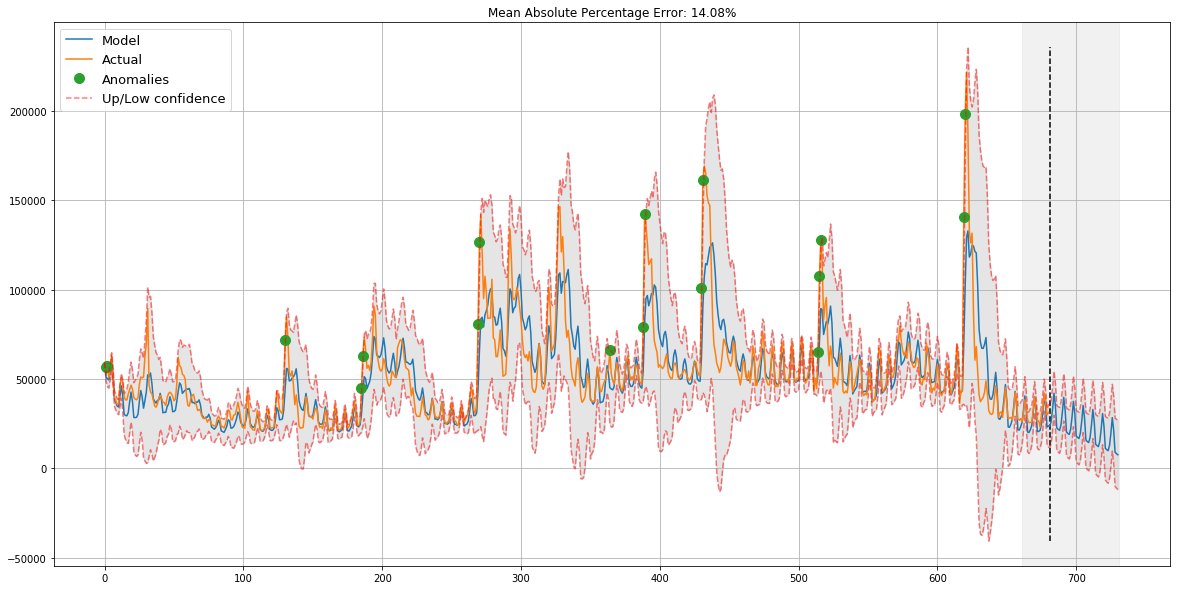

In [24]:
plotHoltWinters(installs.Users[0:-50], plot_intervals=True, plot_anomalies=True)

А теперь обрежем наши данные, чтобы обучаться на последнем промежутке времени, наиболее релевантным для сегодняшних значений

In [28]:
%%time
data = installs.Users[500:-50]
slen = 7
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                      mean_squared_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.2618820126194623 0.022218824066198406 0.020541629867251943
Wall time: 6.49 s


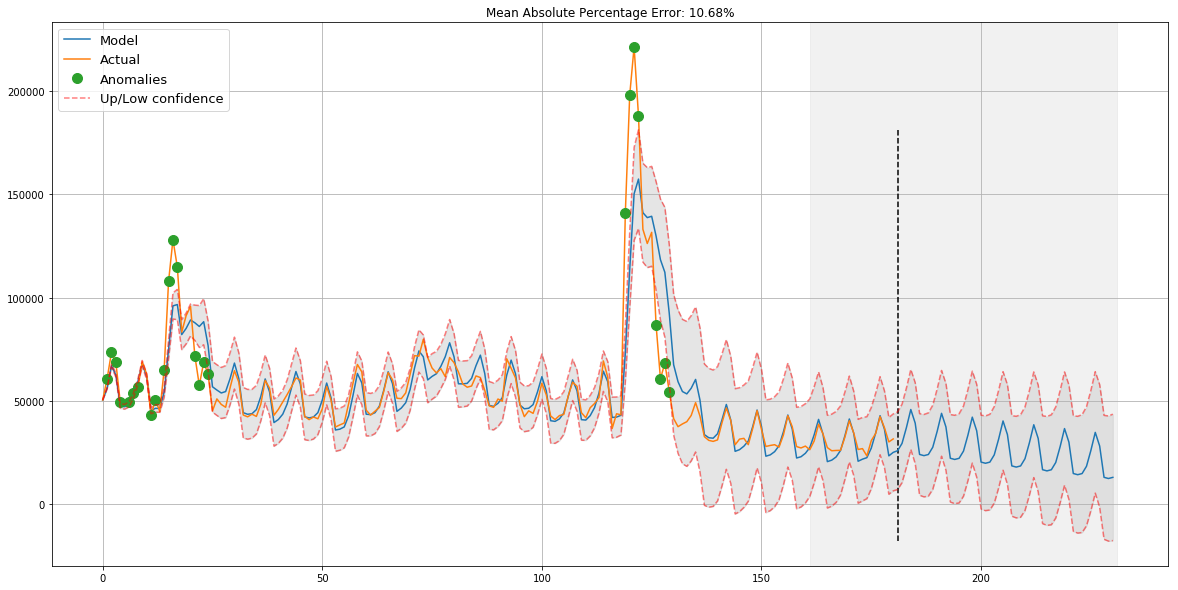

In [29]:
plotHoltWinters(installs.Users[500:-50], plot_intervals=True, plot_anomalies=True)

Прекрасно! Мы снова можем ловить аномалии, а модель неплохо описывает поведение нашего временного ряда и строит правдоподобный прогноз

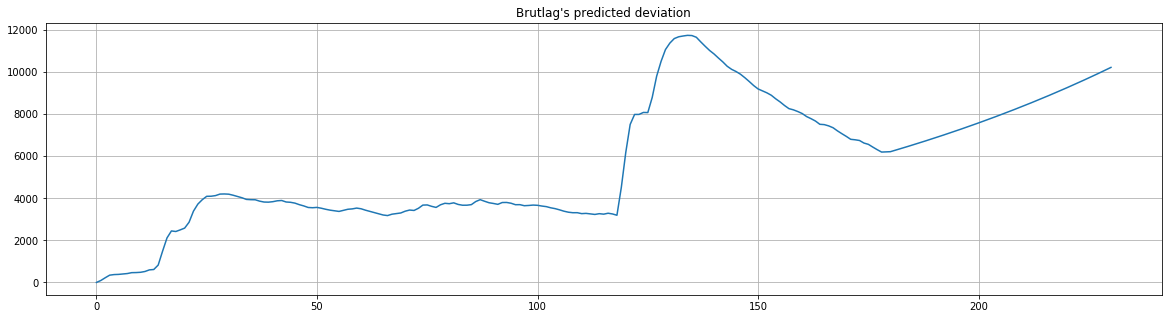

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

По графику смоделированной дисперсии легко увидеть, как выброс в наших данных значительно увеличил отклонение и вызвал расширение доверительных интерваловна некоторых промежуток времени

# Эконометрический подход

In [31]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [32]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(installs.Users, order=(param[0], d, param[1]),  ###########!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [33]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

В качестве домашнего задания и хорошей практики для закрепления - по аналогии с лекцией построить модель SARIMA для прогнозирования временного ряда с тратой внутриигровой валюты, в котором присутствует тренд (убирается при помощи первых разностей) и месячная сезонность (сезонное дифференцирование с периодом 30)

Критерий Дики-Фуллера: p=0.372542


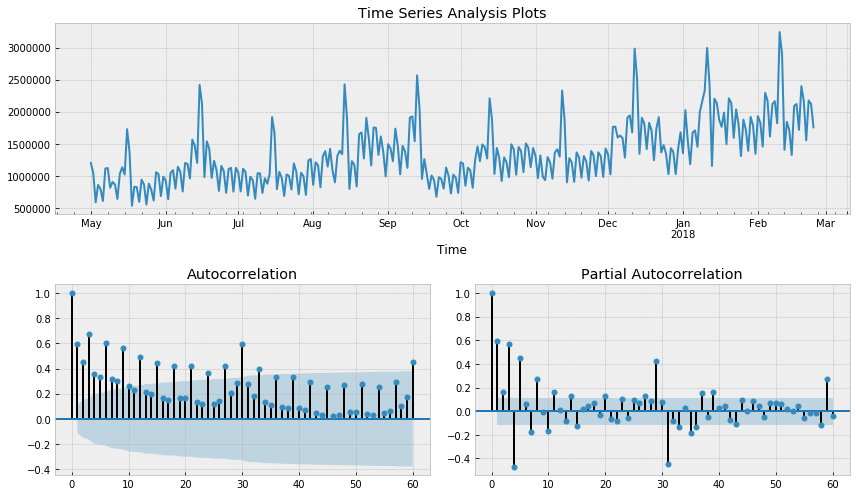

In [35]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

# TODO
# - привести ряд к стационарному виду
# - по ACF, PACF определить начальные значения параметров модели и возможные интервалы
# - перебором параметров подобрать оптимальную модель и построить её
# - построить график модельных значений и остатков, убедиться в адекватности результатов

Критерий Дики-Фуллера: p=0.002438


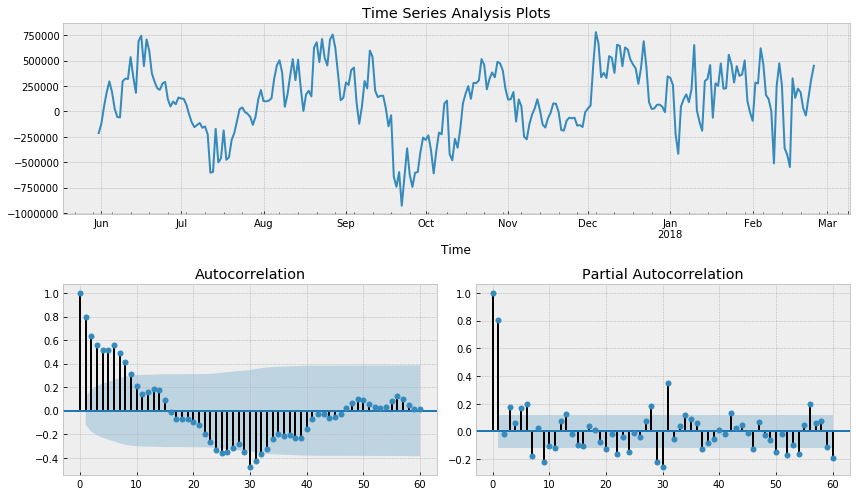

In [36]:
"""При значених по умолчанию Критерий Дики-Фуллера: p=0.372542 - гигантское значение. попробуем уго уменьшить. 
 * Тренд, как будто, отсутствует, т.е., матожидание постоянно, 
 * Разброс вокруг среднего тоже примерно одинаковый, значит, постоянство дисперсии также наблюдается.
 Начнем с сезонности.
 * выполним преобразование под хитрым названием "сезонное дифференцирование", 
 под которым скрывается простое вычитание из ряда самого себя с лагом равным периоду сезонности
 Сполйлер: НЕ плохо: Критерий Дики-Фуллера: p=0.002438

 """
cur_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(30)
tsplot(cur_diff[30:], lags=60)

Критерий Дики-Фуллера: p=0.000061


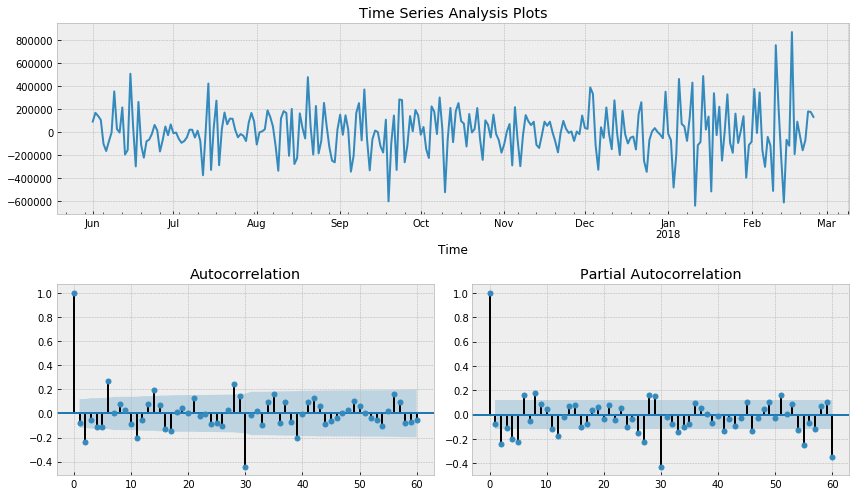

In [37]:
"""Уже лучше, от видимой сезонности избавились, в автокорреляционной функции по-прежнему осталось много значимых лагов, 
попробуем от них избавиться, взяв еще и первые разности - то есть вычитание ряда самого из себя с лагом в один шаг

Спойлер: СУПЕР - Критерий Дики-Фуллера: p=0.000061

Самое время процитировать классиков, ведь лучше и не скажешь: "Отлично, теперь ряд выглядит как непонятно что, 
колеблющееся вокруг нуля, по критерию Дикки-Фуллера он стационарен, 
а в автокорреляционной функции пропали многочисленные значимые пики. Можно приступать к моделированию!"
"""

cur_diff = cur_diff - cur_diff.shift(1)
tsplot(cur_diff[30+1:], lags=60)

In [38]:
# зададим ограничения на возможные значения параметров для перебора
# p = максимальный лаг, который входит в модель, обозначается буквой  p . 
    # Определить начальное значение  p  можно при помощи графика PACF по значимому лагу, 
    # после которого большинство оставшихся лагов становятся не значимыми. 
    # в данном случае = 3 ( но вообще то и 5 и 6 и 7 и др. тоже как будто значимы) или 13 ???
    
# d = порядок интегрированности временного ряда. За этими словами стоит очень простая штука - 
    # сколько нам обычных разностей в ряде пришлось взять, чтобы привести его к стационарному, 
    # такой порядок интегрированности и будет. 
    # В нашем случае это единичка, так как мы взяли от нашего ряда (не считая сезонной ) только первую разность.
    
# q = модель скользящего среднего, если не вдаваться в детали - моделирует случайные ошибки временного ряда, 
    # т.е., как текущая ошибка во временном ряду зависит от предыдущих с некоторым лагом, здесь лаг обозначается буквой  q . 
    # Начальное значение можно определить по графику ACF, логика аналогична.
    # в данном случае, так же  = 3
"""
P  - порядок модели авторегрессии для сезонной компоненты, также определяется по PACF, 
только смотреть нужно на число значимых лагов, кратных периоду сезонности, например, если период равен 30 и выясняется, 
что по PACF значим 30-й и 60-й лаг, то для начального приближения можно взять  P=2 
Q  - аналогично, но для модели скользящего среднего по сезонной компоненте, определяется по ACF

D  - порядок сезонной интегрированности временного ряда. Может быть равен либо 0, либо 1, так как сезонное 
дифференцирование либо проводилось, либо нет
"""    
# P = 2
# D = 1
# Q = 1
# s = 30

ps = range(2, 5) 
d= 1
qs = range(1, 4)

Ps = range(0, 2)
D= 1
Qs = range(0, 2)
s = 30

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [39]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 56min 21s


In [40]:
""" Здесь д.б. получше, чем в следующем"""
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, q), # currency.GEMS_GEMS_SPENT!!!
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(4, 1, 2)x(0, 1, 1, 30)   Log Likelihood               -3614.856
Date:                            Fri, 25 Jan 2019   AIC                           7245.711
Time:                                    09:49:16   BIC                           7274.469
Sample:                                05-01-2017   HQIC                          7257.261
                                     - 02-24-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9456      0.090     10.517      0.000       0.769       1.122
ar.L2         -0.9322      0.110   

In [41]:
result_table.head()

,parameters,aic
0,"(4, 2, 0, 1)",15039.324005
1,"(4, 2, 1, 1)",15039.375393
2,"(3, 3, 1, 1)",15061.509997
3,"(3, 3, 0, 1)",15061.509997
4,"(4, 1, 1, 1)",15066.684808


Критерий Дики-Фуллера: p=0.000014


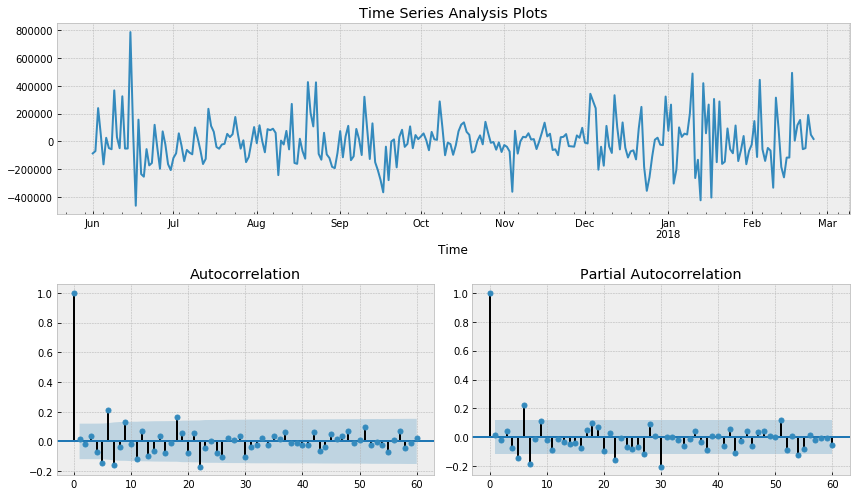

In [42]:
tsplot(best_model.resid[30+1:], lags=60) # Критерий Дики-Фуллера: p=0.000000 - остатки стационарны..

### построим прогноз уже

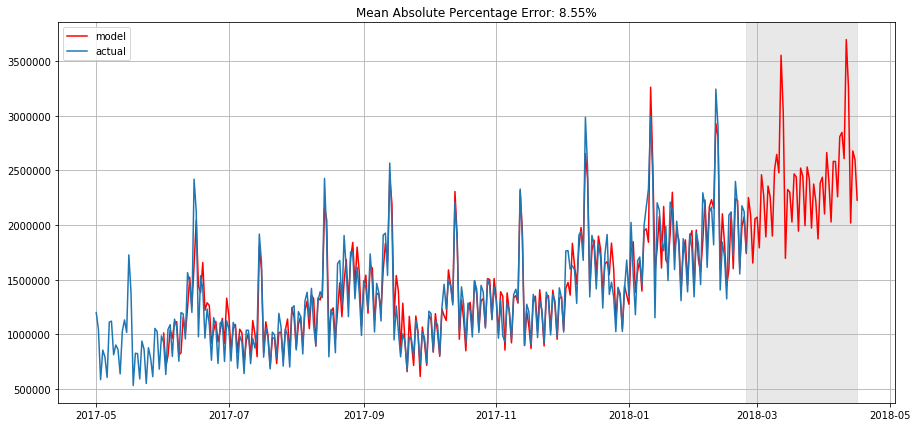

In [43]:
plotSARIMA(currency, best_model, 50) 

### в принципе норм.. но ошибка могла бы бть и по меньше.. 4- например.

In [51]:
""" Еще можно попробовать повыбирать лучшие значения на другом диапазоне (см. ниже), но сильно лучше не будет. 
Поэтому пока на этом остановимся"""
ps = range(2, 4) # ругался на диапазон 12-14
d= 1
qs = range(6, 8)

Ps = range(1, 3)
D= 1
Qs = range(0, 2)
s = 30

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

# Machine Learning для временных рядов

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

scaler = StandardScaler()
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [45]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

Снова небольшим домашним заданием будет построение моделей для временного ряда с внутриигровой валютой.

TODO

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"
- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше
- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат

Крутое бонус-задание
- Разбейте подготовленные данные на `train` и `test`
- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))
- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза
- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`
- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

In [46]:
# Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
data = pd.DataFrame(currency.GEMS_GEMS_SPENT.copy())
data.columns = ["y"]
data.head()

,y
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


In [47]:
# Добавляем лаги целевой переменной
for i in range(7, 31):
    data["lag_{}".format(i)] = data.y.shift(i) # добавим лаги
# посмотрим, как теперь выглядит датасет
data.tail(7)

,y,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
Time,,,,,,,,,,,,,,,,,,,,,
2018-02-18,1716590,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,2172449.0,2294555.0,1455626.0,...,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0,2136402.0,2209397.0,1492338.0
2018-02-19,2398088,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,2172449.0,2294555.0,...,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0,2136402.0,2209397.0
2018-02-20,2166449,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,2172449.0,...,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0,2136402.0
2018-02-21,1552313,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,...,1343029.0,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0
2018-02-22,2175548,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,...,1930747.0,1343029.0,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0
2018-02-23,2122606,2090271.0,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,...,1826320.0,1930747.0,1343029.0,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0
2018-02-24,1756394,2119260.0,2090271.0,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,...,1455626.0,1826320.0,1930747.0,1343029.0,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0


In [48]:
data.shape

(300, 25)

In [595]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [596]:
X_train.shape, X_test.shape

((189, 24), (81, 24))

In [597]:
# учим регрессию
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
# Еще разочек на всякий случай
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0) # построим предсказанные значения по модели
    plt.plot(y_test.values, label="actual", linewidth=2.0) # фатические значения по модели
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error") # будем использовать квадратичное ототклонение ошибки
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std()) # получим из него корень. т.е. просто стандартное отклонение
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

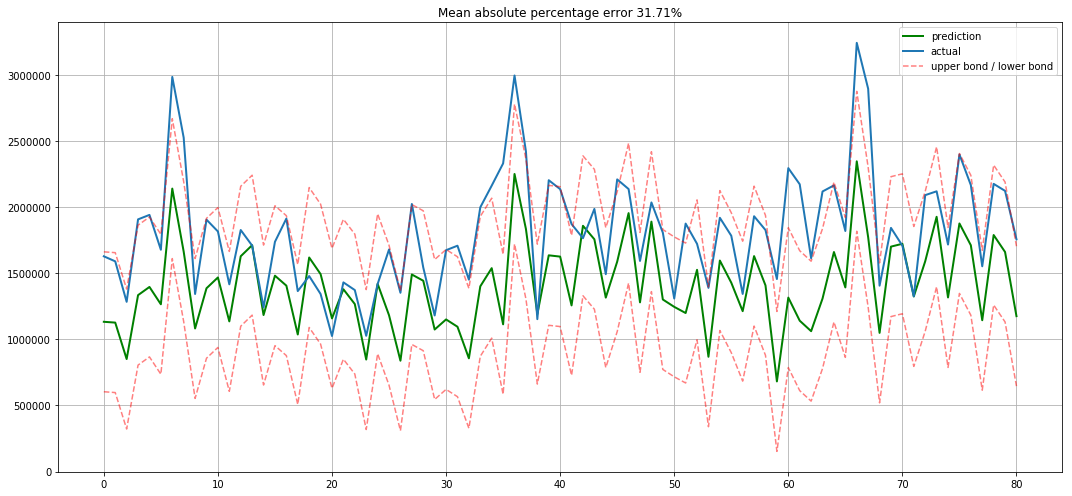

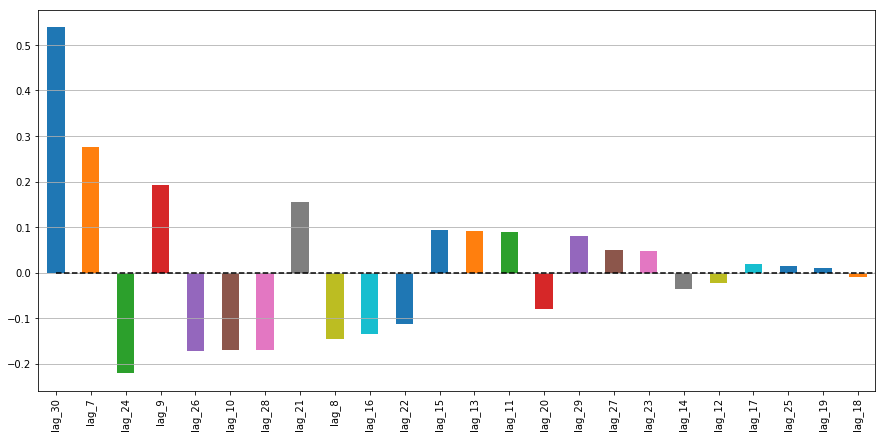

In [599]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

### ужасно... нет слов.. 31.7..  это было получено через стандартную функцию SKLearn timeseries_train_test_split.. 

#### Кодирование средним.
Иногда в качестве признака добавлять среднее значение целевой переменной. В нашем случае каждый день недели, месяц, деньможно закодировать сооветствующим средним числом траты игровой валюты, пришедшиеся на этот месяц  или этот день и т.д. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тренировочного датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем.

In [600]:
data.index = pd.to_datetime(data.index)
data["month"] = data.index.month

data.tail()

,y,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,month
Time,,,,,,,,,,,,,,,,,,,,,
2018-02-20,2166449,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,2172449.0,...,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0,2136402.0,2
2018-02-21,1552313,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,...,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0,2
2018-02-22,2175548,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,...,1343029.0,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,2
2018-02-23,2122606,2090271.0,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,...,1930747.0,1343029.0,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2
2018-02-24,1756394,2119260.0,2090271.0,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,...,1826320.0,1930747.0,1343029.0,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,2


In [601]:
data["month"] = data.index.month
data["day"] = data.index.day
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,month,day,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2018-02-20,2166449,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,2172449.0,...,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0,2136402.0,2,20,1,0
2018-02-21,1552313,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,1612939.0,...,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,1592552.0,2,21,2,0
2018-02-22,2175548,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,2117962.0,...,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2035135.0,2,22,3,0
2018-02-23,2122606,2090271.0,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,2164330.0,...,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,1806885.0,2,23,4,0
2018-02-24,1756394,2119260.0,2090271.0,1324588.0,1707899.0,1842610.0,1405753.0,2894633.0,3242154.0,1819026.0,...,1783279.0,1918963.0,1388952.0,1722011.0,1875120.0,1308255.0,2,24,5,1


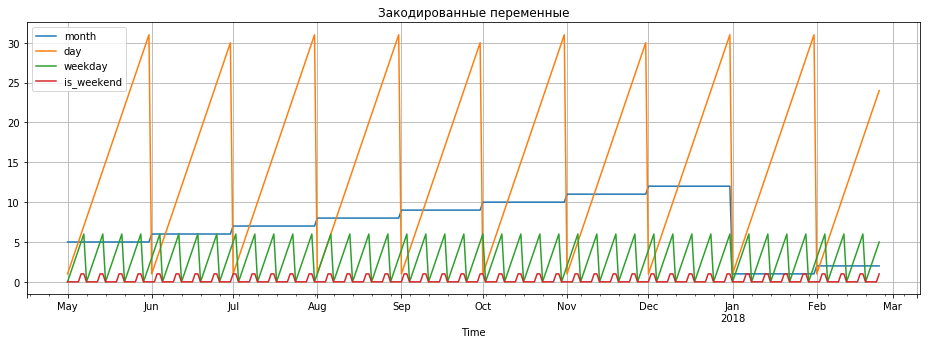

In [602]:
#Визуализируем закодированные признаки
plt.figure(figsize=(16, 5))
plt.title("Закодированные переменные")
data.month.plot(legend=True,label="month")
data.day.plot(legend=True,label="day")
data.weekday.plot(legend=True,label="weekday")
data.is_weekend.plot(legend=True,label="is_weekend")
plt.grid(True);

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этого воспользуемся StandardScaler

In [603]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

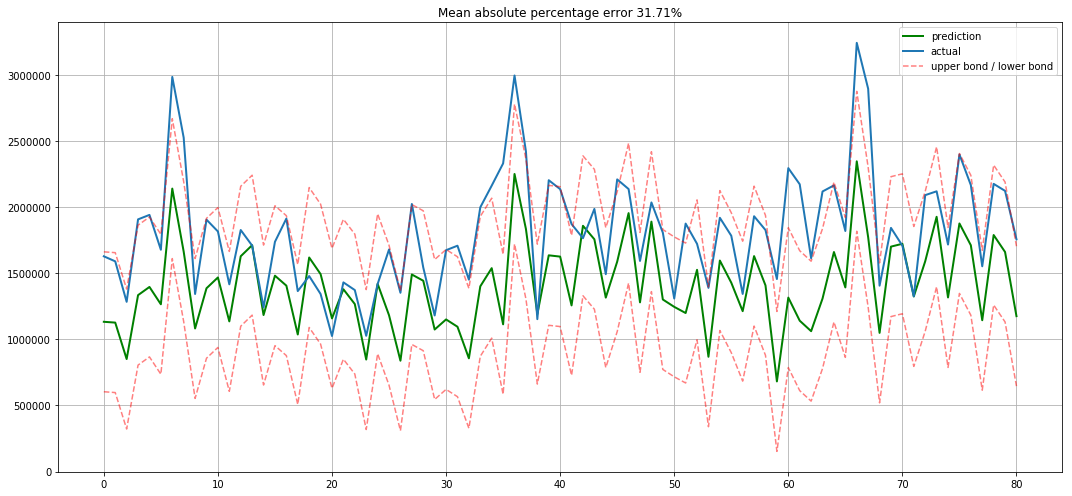

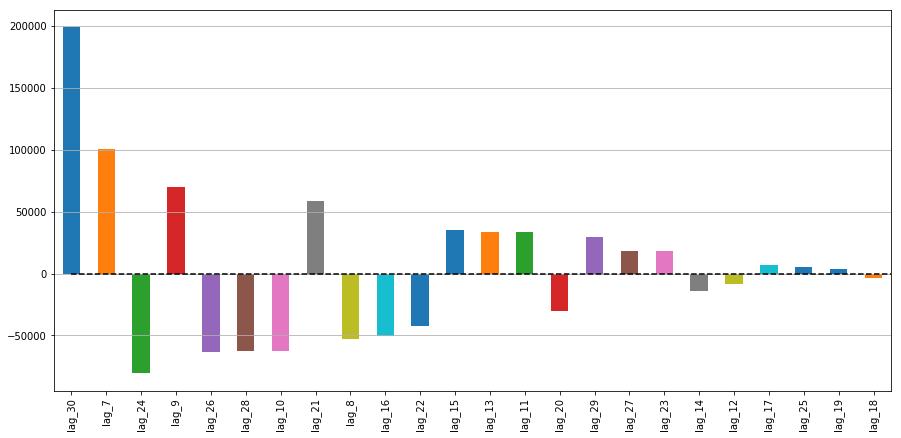

In [68]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

### Еще хуже... странно

In [52]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [606]:
# Посмотрим на среднее по месацам
average_month = code_mean(data, 'month', "y")


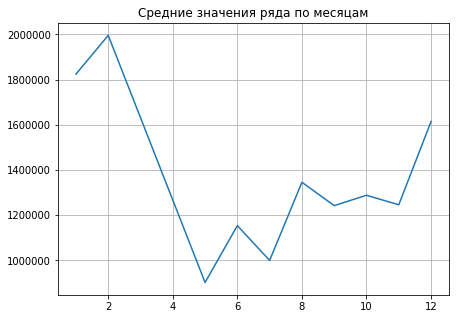

In [607]:
plt.figure(figsize=(7, 5))
plt.title("Средние значения ряда по месяцам")
pd.DataFrame.from_dict(average_month, orient='index')[0].plot()
plt.grid(True);

а попробуем ка мы убрать в связи с этим графиком средний месяц

In [70]:
# Вариант  2. Дал результат 13.6% - Подозреваю можно улучшить, но не будем сейчас перфекционировать (лучшее враг хорошего)
# Воспользуемся этим вариантом
def prepareData_3(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    #data.index = data.index.to_datetime() # было так
    data.index = pd.to_datetime(data.index)
#    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
#        data["month_average"] = list(map(code_mean(data[:test_index], 'month', "y").get, data.month))

        # выкидываем закодированные средними признаки 
        data.drop(["weekday"], axis=1, inplace=True)
#        data.drop(["month"], axis=1, inplace=True)
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

' Таки да - информация о месяцах - реально лишняя'

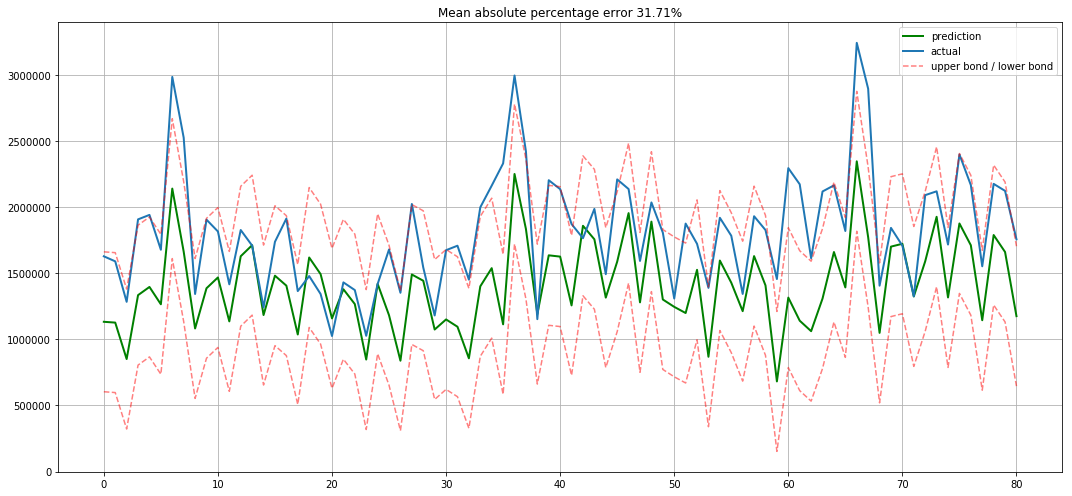

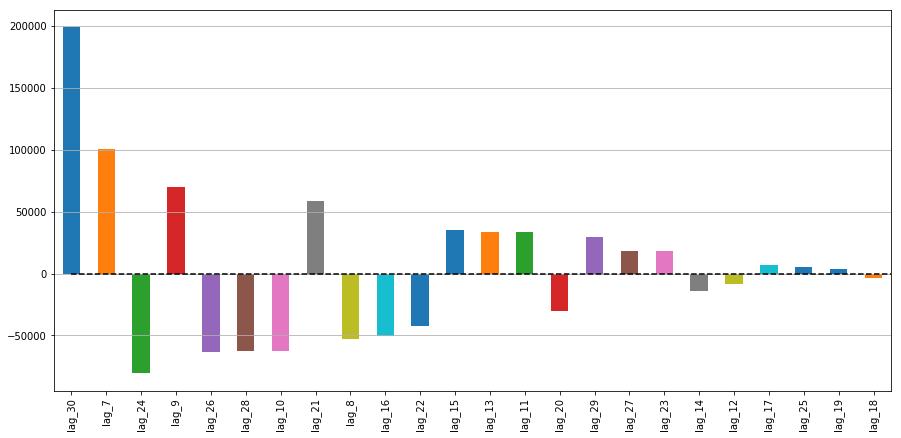

In [75]:
data_alt = data.copy()
#del data_alt['month']

y = data_alt.dropna().y
X = data_alt.dropna().drop(['y'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)
""" Таки да - информация о месяцах - реально лишняя"""

Итак, продолжим смотреть на средние

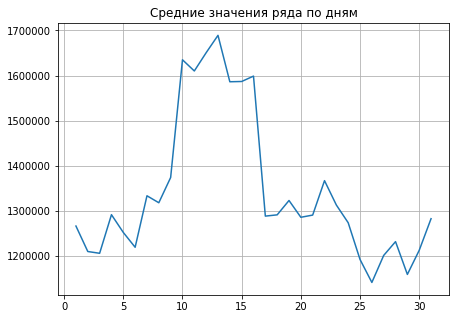

In [609]:
# Посмотрим на среднее по дням
average_day = code_mean(data, 'day', "y")

plt.figure(figsize=(7, 5))
plt.title("Средние значения ряда по дням")
pd.DataFrame.from_dict(average_day, orient='index')[0].plot()
plt.grid(True);

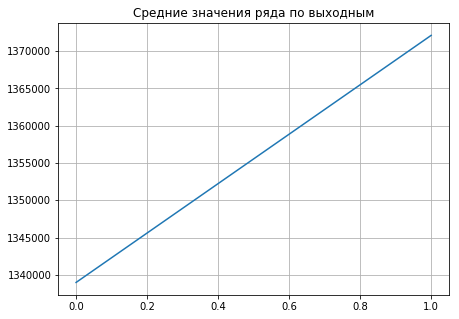

In [610]:
# Посмотрим на среднее по выходным
average_weekend = code_mean(data, 'is_weekend', "y")

plt.figure(figsize=(7, 5))
plt.title("Средние значения ряда по выходным")
pd.DataFrame.from_dict(average_weekend, orient='index')[0].plot()
plt.grid(True);

А теперь, объединим все преобразования под одной функцией и добавим к признакам кодирование средним

In [64]:
# Вариант  1. Дал результат 19% - оставим для потомков
def prepareData_1(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по году, месяцу, дате, дню недели и выходным
    data.index = pd.to_datetime(data.index)
    
    data["day"] = data.index.day     
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data["month"] = data.index.month
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать пика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))    
        data["day_average"] = list(map(code_mean(data[:test_index], 'day', "y").get, data.day))
        data["is_weekend_average"] = list(map(code_mean(data[:test_index], 'is_weekend', "y").get, data.is_weekend))
        data["month_average"] = list(map(code_mean(data[:test_index], 'month', "y").get, data.month))
        
        # выкидываем закодированные средними признаки 
        data.drop(["day", "weekday", "is_weekend"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [65]:
# Вариант  2. Дал результат 13.6% - Подозреваю можно улучшить, но не будем сейчас перфекционировать (лучшее враг хорошего)
# Воспользуемся этим вариантом
def prepareData_2(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    #data.index = data.index.to_datetime() # было так
    data.index = pd.to_datetime(data.index)
    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["month_average"] = list(map(code_mean(data[:test_index], 'month', "y").get, data.month))

        # выкидываем закодированные средними признаки 
        data.drop(["month", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

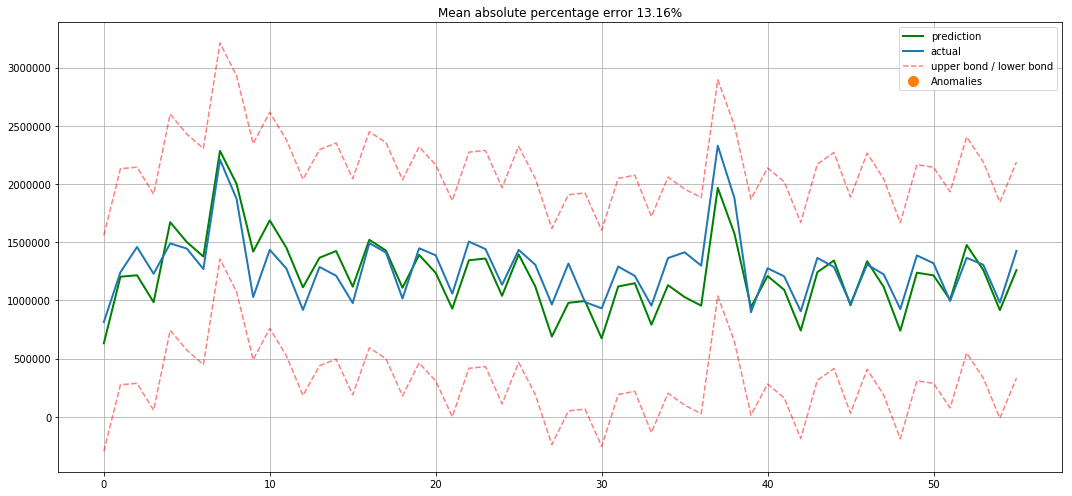

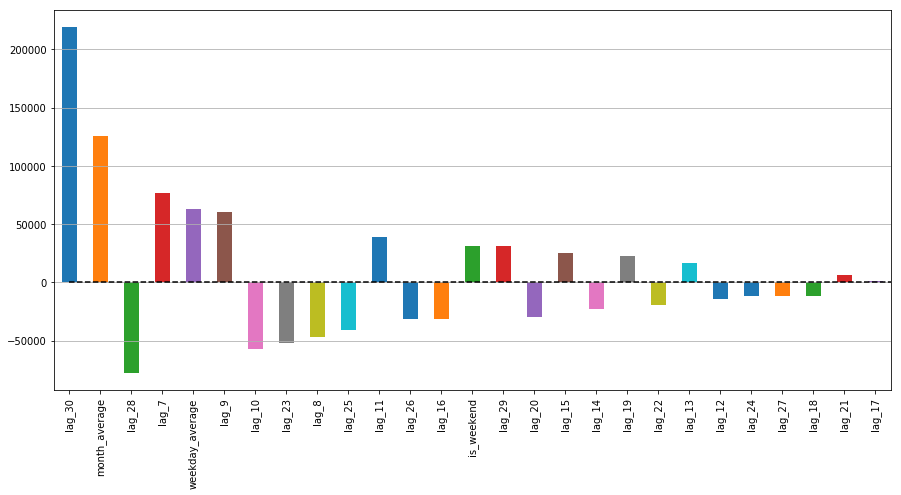

In [78]:
X_train, X_test, y_train, y_test = prepareData_2(currency.GEMS_GEMS_SPENT, lag_start=7,lag_end=31, test_size=0.3, target_encoding=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

### Кодирование средним прям чудеса творит!

## Регуляризация и отбор признаков
Для начала убедимся, что нам есть, что отбрасывать и в данных действительно очень много скоррелированных признаков

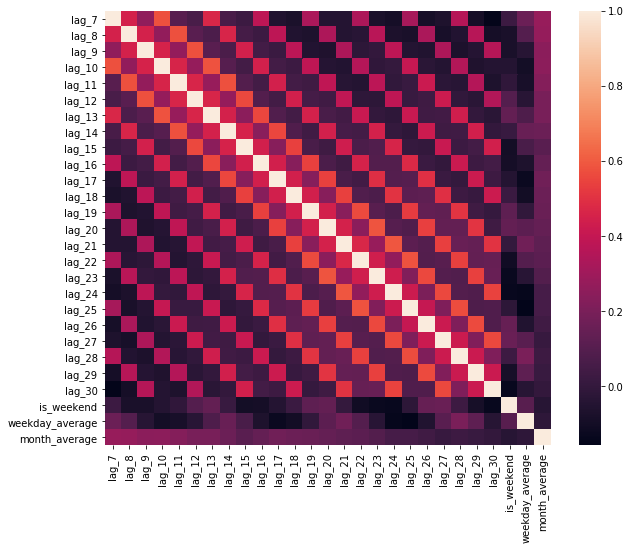

In [79]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

нууу не знаааю... прям вот сильно скоррелированных параметров по мне так нет.. или отрицательная скоррелированность - тоже скоррелированность?

In [615]:
from sklearn.linear_model import LassoCV, RidgeCV
# импортируем Лассо и Ридж, обе с кросвалидацией, чтоб параметры сами настраивались

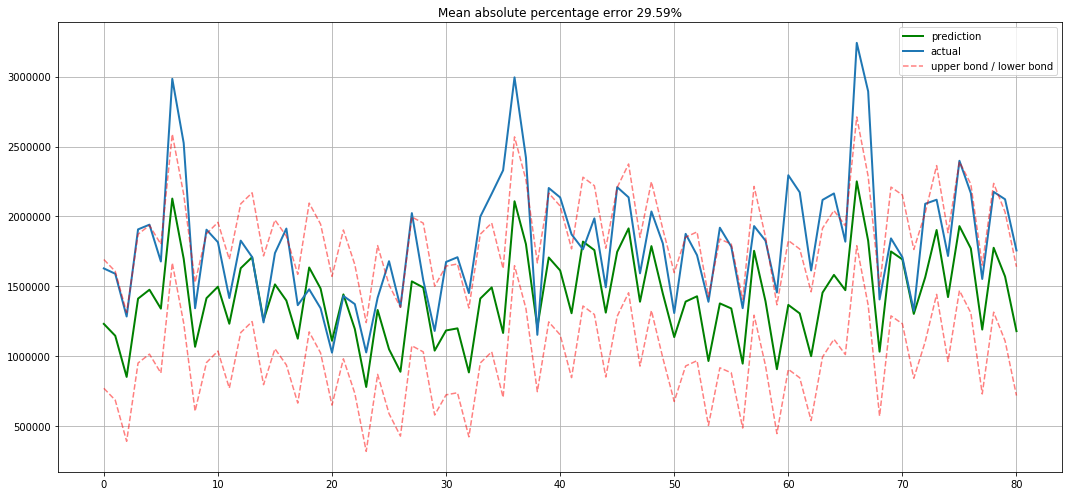

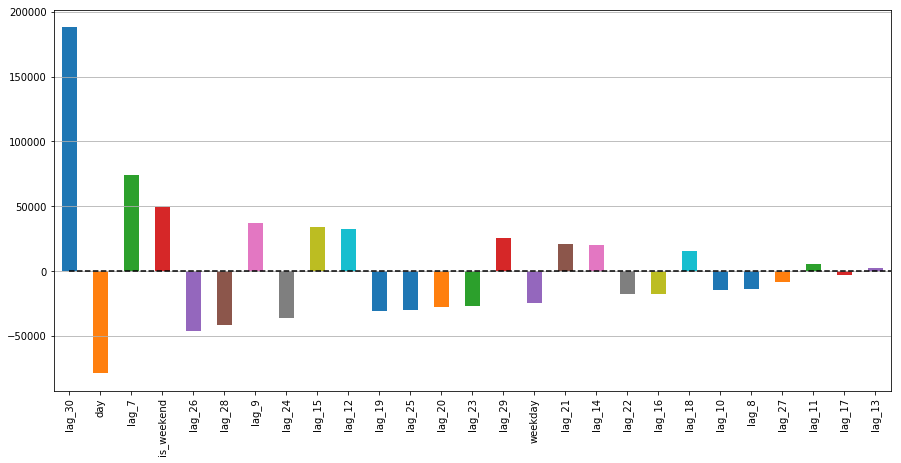

In [616]:
ridge = RidgeCV(cv=tscv) # передадим timeseries в cv split, который позволяет кросвалидировать по временному ряду
ridge.fit(X_train_scaled, y_train) # обучаем модельку

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(ridge)

Ну как бы да - к нулю прибилжаемся, но все равно  MAE около 30%

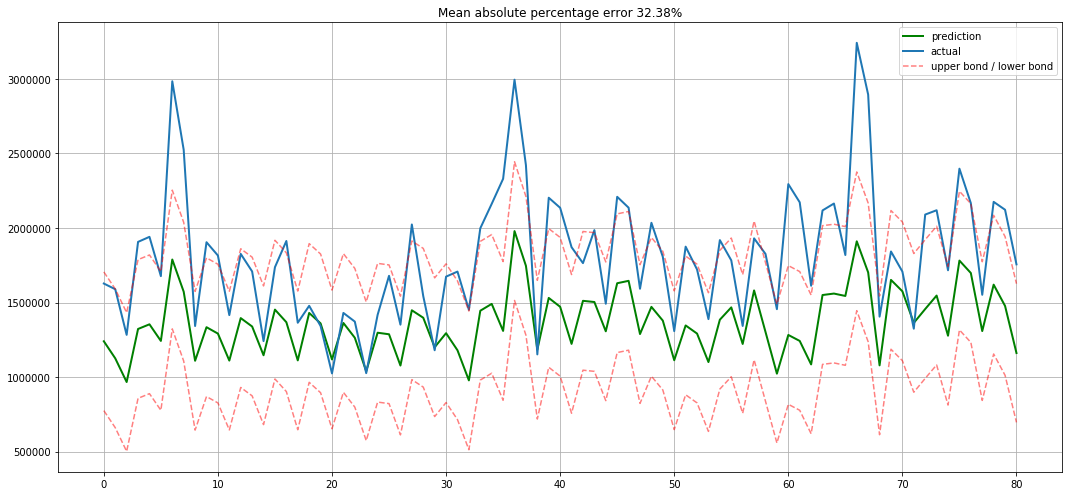

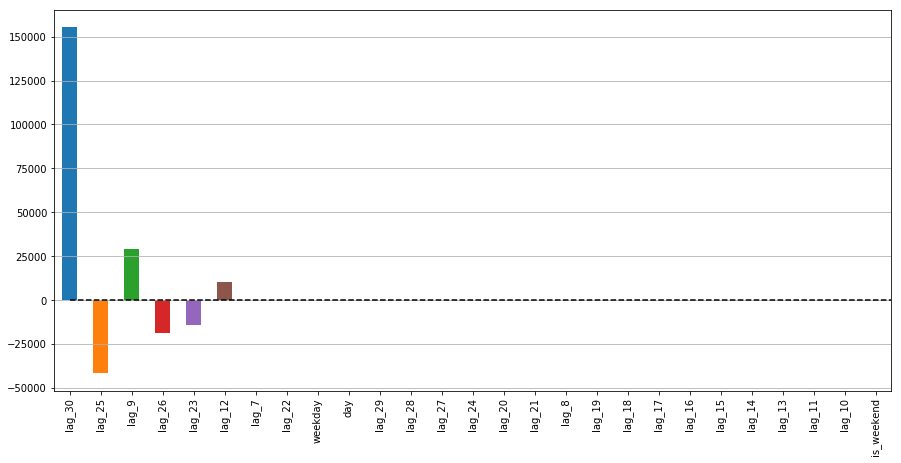

In [617]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)
plotCoefficients(lasso)

Да не, ну жесть же действительно ...

### Попробуем XGBoost

In [80]:
from xgboost import XGBRegressor 

In [81]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [85]:
X_train_scaled.shape

(128, 27)

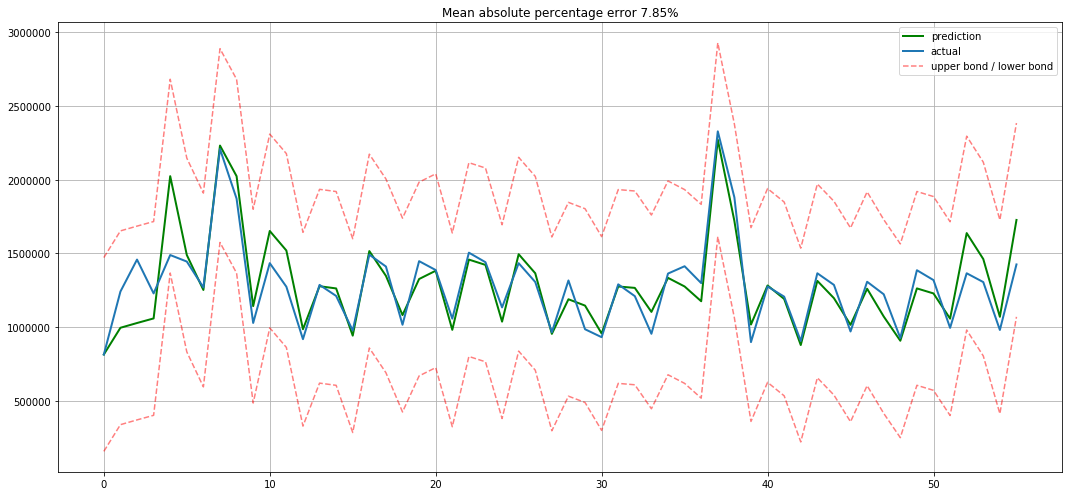

In [86]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True)